In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings
warnings.simplefilter("ignore")

- 드라이브에 있는 train_X_df, train_y_df를 사용 -> 다음 버전으로 20231211_final의 데이터 셋을 사용해보겠습니다.

In [2]:
X_trn = pd.read_csv("/home/sangjun/work/data/train_X_231211.csv")
X_origin = X_trn.copy()
y_trn = pd.read_csv("/home/sangjun/work/data/train_y_231211.csv")
X_trn.drop("depressed", axis=1,inplace=True) # depressed가 있어서 삭제

사용할 feature

In [3]:
num_features = ['HE_chol', 'HE_Bplt', 'HE_wt', 'HE_ht', 'HE_RBC', 'HE_HDL_st2', 'HE_HB', 'age', 'HE_Uph', 'HE_crea', 'HE_Usg', 'HE_WBC', 'HE_TG', 'HE_alt', 'HE_ast',
 'HE_HCT', 'HE_dbp', 'HE_glu', 'HE_BUN', 'ainc', 'HE_sbp', 'HE_wc']
onehot_features = ['BO2_1', 'educ', 'BH1', 'EC_stt_2', 'sex', 'HE_Unitr', 'LQ4_00', 'DI1_pt', 'BM1_5', 'DE1_pt', 'DJ4_pt', 'HE_Ubld', 'LQ1_sb', 'BM1_8', 'occp', 'DI2_pr',
 'BD1', 'marri_1', 'DI3_pr', 'BM1_3', 'EC_occp', 'BM1_4', 'live_t', 'HE_Ubil', 'BH2_61', 'DI1_pr', 'EC_stt_1', 'BM1_7', 'DJ4_pr', 'DE1_pr', 'HE_Uglu',
 'HE_Uro', 'HE_Upro', 'HE_Uket', 'HE_obe', 'HE_rPLS', 'BO1_1', 'BO1', 'D_2_1', 'BM1_1', 'npins', 'LQ2_ab', 'BH9_11', 'tins', 'DI2_pt', 'BM1_2',
 'DI3_pt', 'BS8_2', 'BS9_2', 'BM1_6']
label_features = ['BD1_11', 'incm', 'ho_incm', 'incm5', 'ho_incm5', 'D_1_1', 'cfam', 'BA2_13', 'BS3_1', 'DI3_2', 'house', 'BA2_12', 'BE3_31', 'edu', 'BD2_1', 'BE5_1']
y_related =["BP_PHQ_1","BP_PHQ_2","BP_PHQ_3","BP_PHQ_4","BP_PHQ_5","BP_PHQ_6","BP_PHQ_7","BP_PHQ_8","BP_PHQ_9","mh_PHQ_S","BP6_10","BP6_31","DF2_pr","DF2_pt","BP1"]
y = "depressed"

- trasform function을 추가

In [4]:
### 임시 -transform
def transform(X, y, num_features,onehot_features,label_features, y_related):
    ### 결측값 처리 3 - fillna: KNN
    from sklearn.impute import KNNImputer
    from sklearn.impute import SimpleImputer

    # 1) num_features 결측값 처리 - KNN
    knn_imp = KNNImputer(n_neighbors=5)
    X[num_features] = knn_imp.fit_transform(X[num_features])

    # # 2) onehot_features, label_features 결측값 처리 - 최빈값(most frequent values)
    freq_imp = SimpleImputer(strategy = "most_frequent")
    X[onehot_features] = freq_imp.fit_transform(X[onehot_features])
    X[label_features] = freq_imp.fit_transform(X[label_features])

    # transform array(X) to dataframe
    df_new = pd.DataFrame(X, columns=X.columns) 
    df_new.isna().sum().sort_values(ascending = False)

    ### 인코딩
    # 1. numeric # 1. numeric - scaling 
    from sklearn.preprocessing import MinMaxScaler 
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_new[num_features] = scaler.fit_transform(df_new[num_features])
    # # 2. onehot -> onehot 인코딩으로 진행
    df_new = pd.get_dummies(df_new, columns=onehot_features) # sklearn OneHotEncoder 사용도 가능함

    ### 샘플링
    # under sampling.  OVER 만 하기엔 너무 많이 생성해야해서 under 선수행
    from imblearn.under_sampling import RandomUnderSampler

    X = df_new
    rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    X_under, y_under = rus.fit_resample(X, y)
    X_under.shape, y_under.shape

    # over sampling
    from imblearn.over_sampling import SMOTE

    smote = SMOTE(random_state=42)
    X_over, y_over = smote.fit_resample(X_under, y_under)

    X_over.shape, y_over.shape

    return X_over, y_over


In [5]:
X_over, y_over = transform(X_trn, y_trn, num_features,onehot_features,label_features, y_related)

In [6]:
# X_test_over, y_test_over = transform(tst_X[num_features], tst_y, num_features, y_related)
# #override
# X_test_over = tst_X[num_features]
# y_test_over = tst_y

In [7]:
X_over.shape, y_over.shape,

((26852, 219), (26852, 1))

노트북 파일이다 보니 그때 그때 삭제할 컬럼을 바로 삭제했습니다. 예시로 Top2인 컬럼 "BS9_2_8.0"을 삭제

In [8]:
X_over = X_over.drop("BS9_2_8.0", axis=1)

In [9]:
# X_test_over.shape, y_test_over.shape

- RandomUnderSampler(sampling_strategy=0.5, random_state=42)

In [10]:
# 5가지의 scoring을 볼 예정
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=2023)
# StratifiedKFold를 사용하
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

# 교차 검증
results = cross_validate(clf, X_over, y_over, scoring=scoring, cv=cv) # 5fold

# 결과 출력
results_df = pd.DataFrame(results)
pd.concat([results_df, results_df.apply(['mean', 'std'])])

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
0,9.602217,0.486614,0.810277,0.839446,0.767225,0.801712,0.898839
1,9.767883,0.504045,0.803575,0.833538,0.758749,0.794387,0.890869
2,9.608071,0.514839,0.803538,0.834840,0.756797,0.793905,0.887805
3,9.866853,0.523375,0.814153,0.845272,0.769088,0.805382,0.895499
4,9.730675,0.526831,0.815829,0.852159,0.764246,0.805812,0.898050
mean,9.715140,0.511141,0.809474,0.841051,0.763221,0.800240,0.894212
std,0.112088,0.016290,0.005765,0.007727,0.005310,0.005789,0.004744


- 왜 5fold로 나누었는데 갈수록 값이 증가할까? -> StratifiedKFold가 적용이 안되어서다.


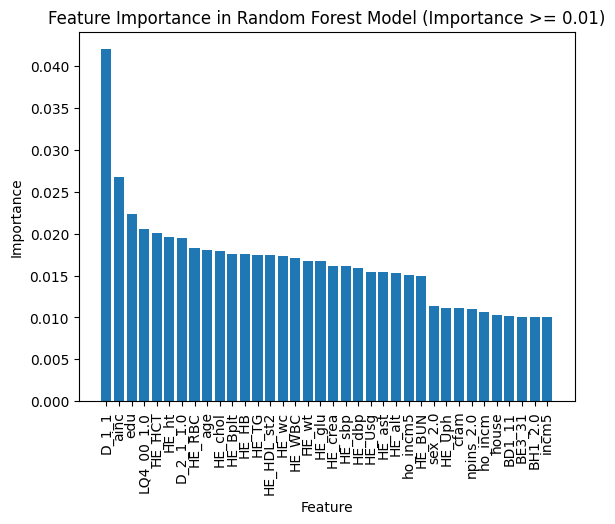

In [11]:
# 사용 모델
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=2023)

model.fit(X_over, y_over)

# Feature 중요도 계산
feature_importances = model.feature_importances_

# 중요도가 0.01 이상인 feature만 선택
selected_features = X_over.columns[feature_importances >= 0.01]

# 중요도를 DataFrame으로 변환
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_over.columns,
    'Importance': feature_importances
})

# Feature 중요도 시각화
selected_idx = np.argsort(feature_importances[feature_importances >= 0.01])[::-1]

plt.bar(range(len(selected_features)), feature_importances[feature_importances >= 0.01][selected_idx], align="center")
plt.xticks(range(len(selected_features)), selected_features[selected_idx], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in Random Forest Model (Importance >= 0.01)")
plt.show()

In [12]:
rf_feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

,Feature,Importance
29,D_1_1,0.041968
1,ainc,0.026756
26,edu,0.022373
60,LQ4_00_1.0,0.020608
14,HE_HCT,0.020098
4,HE_ht,0.019598
184,D_2_1_1.0,0.019450
18,HE_RBC,0.018257
0,age,0.018025
8,HE_chol,0.017980


간단한 실험용 MLP를 이용해서 feature importance 구해보기

In [13]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

ann_model = MLPClassifier(hidden_layer_sizes=(32,), 
                          max_iter=100, 
                          random_state=2023, 
                          solver='adam',
                          batch_size=32,
                          learning_rate='constant',)
ann_model.fit(X_train, y_train)

# permutation feature importance 계산
result = permutation_importance(ann_model, X_test, y_test, n_repeats=30, random_state=42)

# 중요도 및 관련 정보를 DataFrame으로 변환
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
})

# 중요도를 기준으로 내림차순 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance_Mean', ascending=False)

# 결과 출력
feature_importance_df

# 결과 출력
# print("Permutation Feature Importance:")
# for i, imp in enumerate(result.importances_mean):
#     print(f"Feature {i}: {imp}")


In [ ]:
feature_importance_df.head()

,Feature,Importance_Mean,Importance_Std
29,D_1_1,0.016902,0.004394
26,edu,0.016394,0.003629
32,BD2_1,0.012534,0.004683
1,ainc,0.010486,0.003858
214,BS9_2_3.0,0.008029,0.003479


In [ ]:
sort_importance = sorted(result.importances_mean,reverse=True)
sort_importance

[0.016902457185405846,
 0.01639364606602137,
 0.012534127575080708,
 0.010486473070240799,
 0.0080292876644329,
 0.007259865971705178,
 0.0058451228592703245,
 0.0057830727227600265,
 0.005088111193844665,
 0.005088111193844665,
 0.004343509555721059,
 0.0038719285182427805,
 0.00376023827252423,
 0.0036857781087118644,
 0.003598907917597453,
 0.0033879374534624344,
 0.003387937453462427,
 0.003301067262348019,
 0.003288657235045944,
 0.0032141970712335896,
 0.0031397369074212273,
 0.0030280466617026843,
 0.0028791263340779785,
 0.0027922561429635563,
 0.0027550260610573604,
 0.0025068255150161867,
 0.0023703152146935117,
 0.0023082650781832137,
 0.002122114668652297,
 0.002109704641350252,
 0.002097294614048199,
 0.0020476545048399427,
 0.002010424422933758,
 0.0018739141226111053,
 0.0017746339041946261,
 0.0017374038222884524,
 0.0016629436584760867,
 0.001638123603871966,
 0.0016008935219657887,
 0.0016008935219657813,
 0.0015760734673616716,
 0.0015760734673616642,
 0.001526433358

### 결론
- Random Forest를 이용하여 학습시 영향 많이 주는 속성은 없음 아마 ANN에 사용한 feature를 그대로 사용하다 보니 이렇게 된것 같다
- Kfold를 사용할때 왜 score가 점점 증가하는지 이유를 모르겠습니다.


추가로 Heatmap 분석한 부분입니다.

train_X_df의 각 feature들의 상관관계를 분석하고 depressed와 얼마나 연관이 있는지 봅니다.

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,15)})

In [ ]:
df_new = X_over

## numerical features의 상관관계

- 사용 features

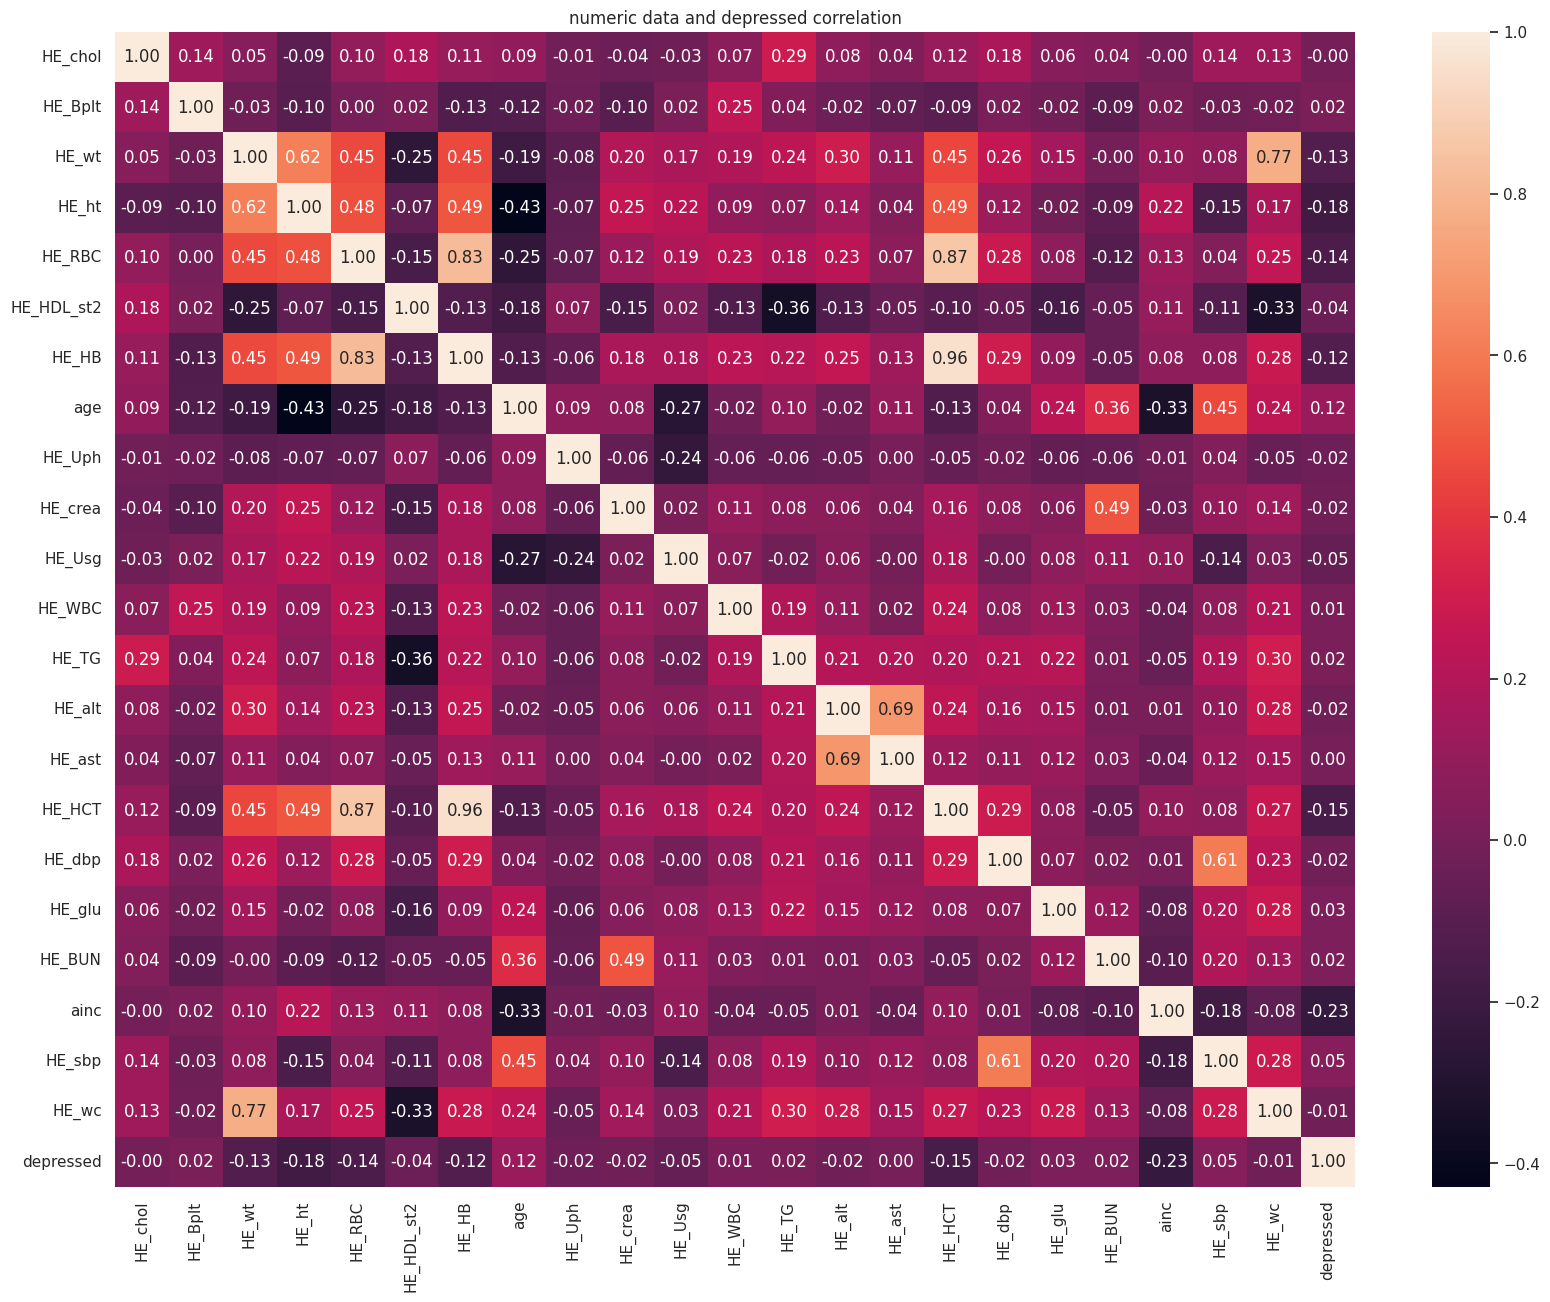

In [ ]:
df_num = pd.concat([df_new[num_features],y_over], axis=1)
sns.heatmap(df_num.corr(), annot=True, fmt='.2f')
plt.title("numeric data and depressed correlation")
plt.show()

## label features의 상관관계

- 사용 features

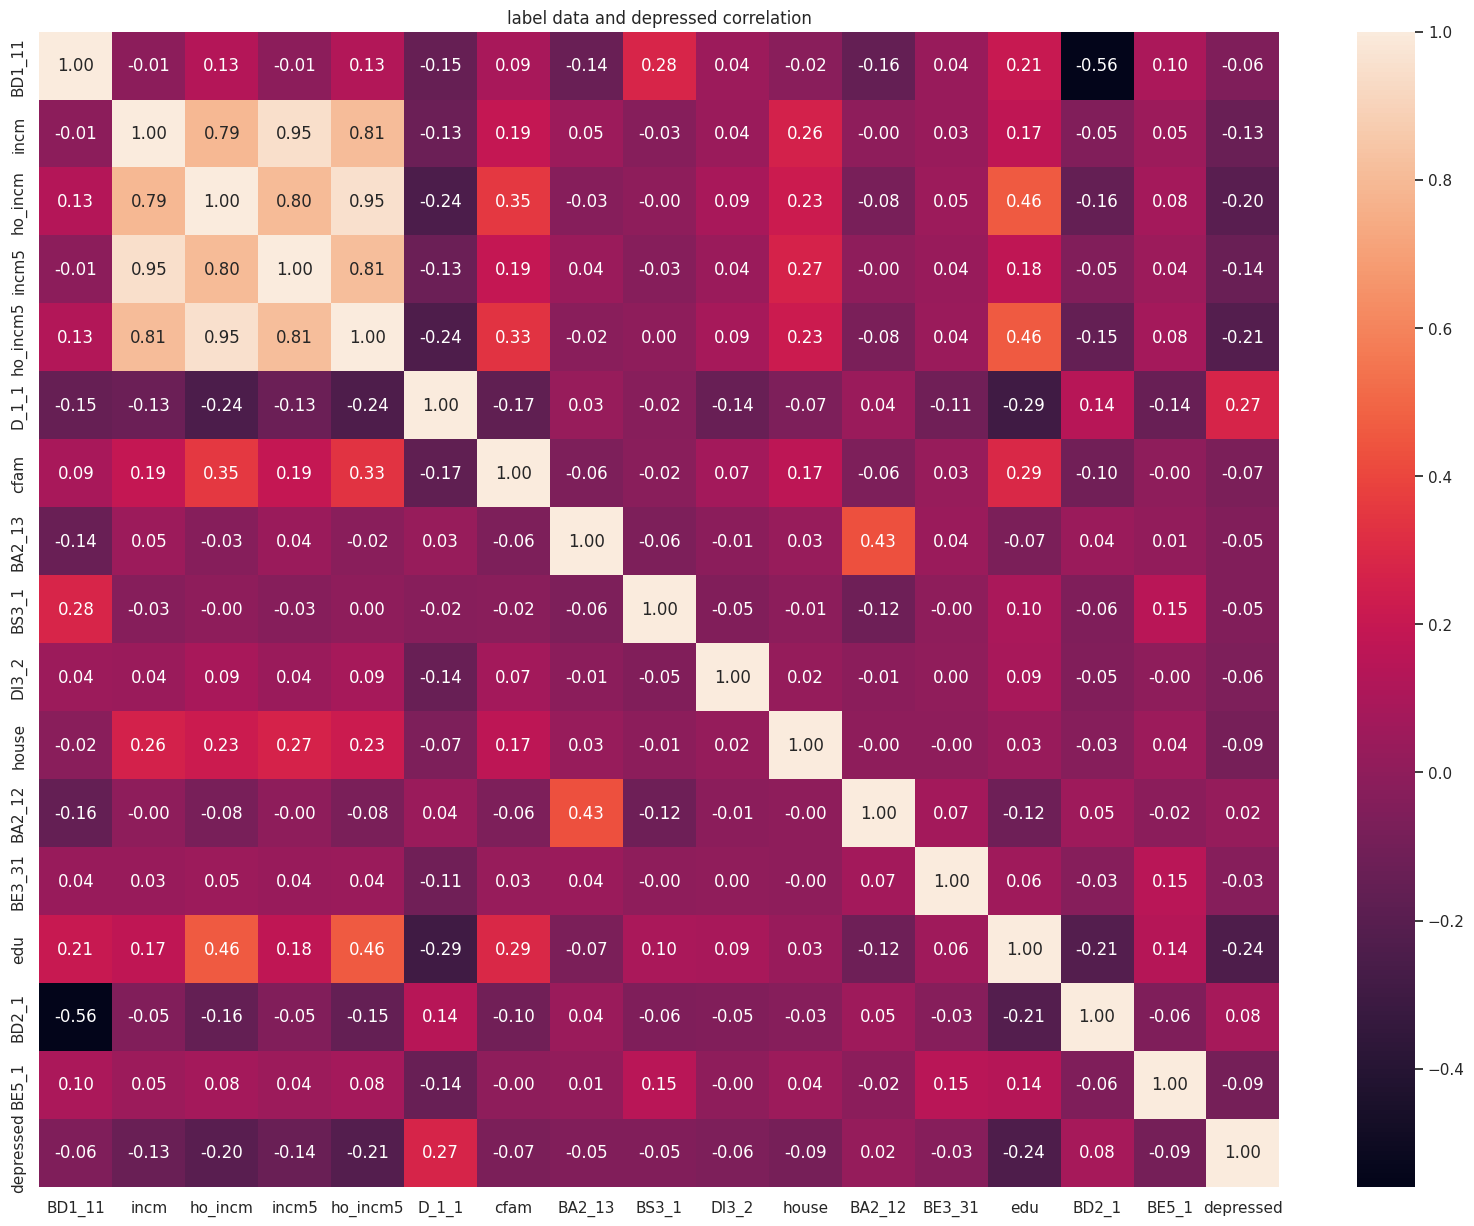

In [ ]:
df_label = pd.concat([df_new[label_features],y_over], axis=1)
sns.heatmap(df_label.corr(), annot=True, fmt='.2f')
plt.title("label data and depressed correlation")
plt.show()

## OneHot Features의 상관관계

- 사용 features

In [ ]:
df_onehot = df_new.drop(num_features+label_features, axis=1)
df_onehot = pd.concat([df_onehot,y_over],axis=1)

- 상관관계가 0.15보다 높은 값만 선택합니다.

In [ ]:
correlation_matrix = df_onehot.corr()
threshold = 0.15

relevant_corr = correlation_matrix['depressed'][correlation_matrix['depressed'].abs() > threshold]

relevant_corr_matrix = df_onehot[relevant_corr.index].corr()

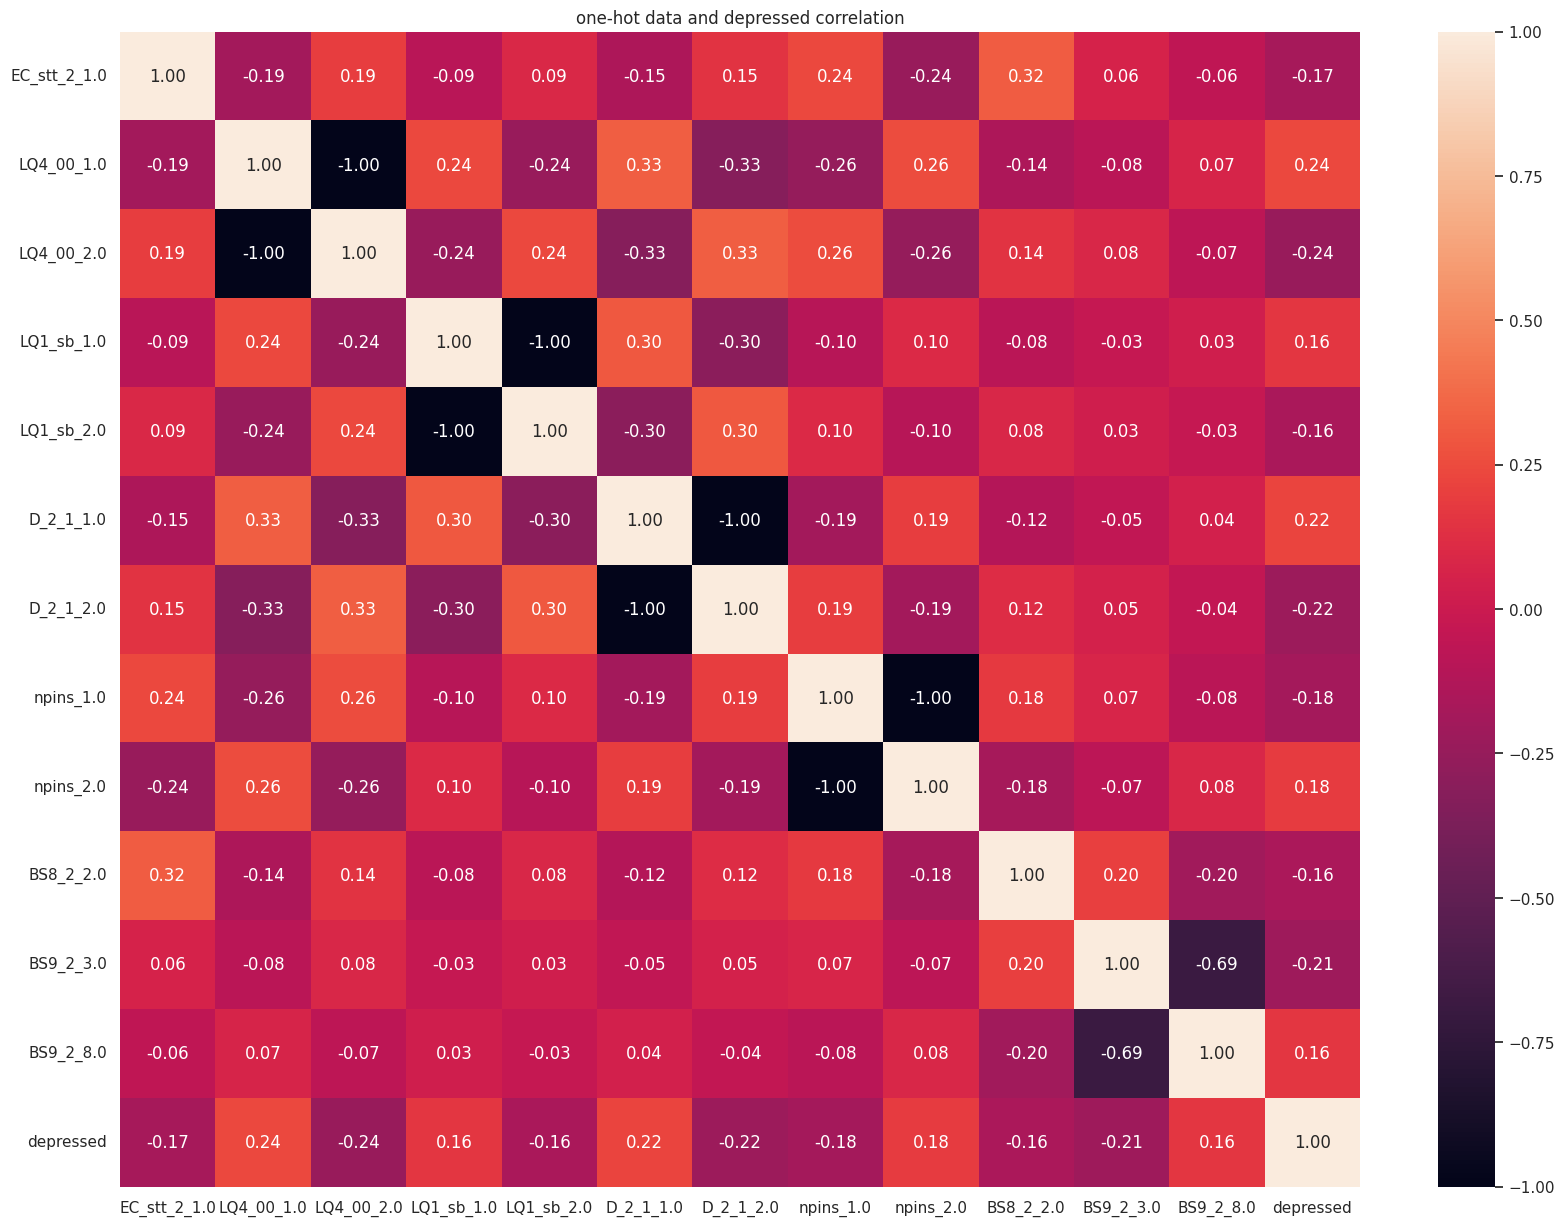

In [ ]:
# sns.set(rc={'figure.figsize':(25,20)})

sns.heatmap(relevant_corr_matrix, annot=True, fmt='.2f')
plt.title("one-hot data and depressed correlation")
plt.show()

depressed와 유의미하게 관계가 있는 features는 존재하지 않는것 같습니다. 따라서 머신러닝 모델에서는 성능이 그렇게 좋지는 않을 것으로 위 관계만 본다면 미리 예상 가능하고, 하지만 feature가 많은게 어떤 변수를 가져올지는 모르겠습니다.